# Line Profile Analysis: Probing Parameter Spaces
Some tests of looking at line profile parameters in different ways. This usese a small subset of some old data and is just for testing purposes.

In [1]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors
import astropy.modeling
import astropy.units as u
import astropy.constants as const
import sunpy.map
import pandas

from synthesizAR.util import EISCube
from synthesizAR.atomic import EmissionModel

%matplotlib inline

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


 using cli
 using CLI for selections
 reading chiantirc file


## Load Emission Model

In [2]:
emiss_model = EmissionModel.restore('/home/wtb2/Desktop/test_ar_analysis/emission_model1109_full/',load_emissivity=False)

H I psplups file not found
He II psplups file not found
N VII psplups file not found
O VIII psplups file not found
Ne X psplups file not found
Na XI psplups file not found
Mg XII psplups file not found
Al XIII psplups file not found
Si XIV psplups file not found
P XV psplups file not found
S XVI psplups file not found
Cl XVII psplups file not found
Ar XVIII psplups file not found
K XIX psplups file not found
Ca XX psplups file not found
Fe XXVI psplups file not found
Ni XXVIII psplups file not found
He I psplups file not found
C V psplups file not found
N VI psplups file not found
O VII psplups file not found
Ne IX psplups file not found
Na X psplups file not found
Mg XI psplups file not found
Al XII psplups file not found
Si XIII psplups file not found
P XIV psplups file not found
S XV psplups file not found
Cl XVI psplups file not found
Ar XVII psplups file not found
K XVIII psplups file not found
Ca XIX psplups file not found
Fe XXV psplups file not found
Ni XXVII psplups file not f

## Data Munging
### Low-frequency Heating

In [3]:
channel1_cube_low = EISCube('/home/wtb2/Desktop/test_ar_analysis/low_frequency/170-210/map_t000750.h5')

In [4]:
i_wave = np.argwhere(np.isclose(channel1_cube_low.wavelength.value,
                       emiss_model.ions[230].resolved_wavelengths[1].value,atol=1e-2,rtol=0.))[0][0]

In [5]:
fe12_cut_low = channel1_cube_low[i_wave-10:i_wave+10]
fe12_cut_low_cropped = fe12_cut_low.submap(u.Quantity([270,450],u.arcsec),u.Quantity([150,370],u.arcsec))

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/sunpy/map/mapbase.py:1593: Warning: WCSAxes is installed but not being used. Plots may not have the expected behaviour.
  Warning)


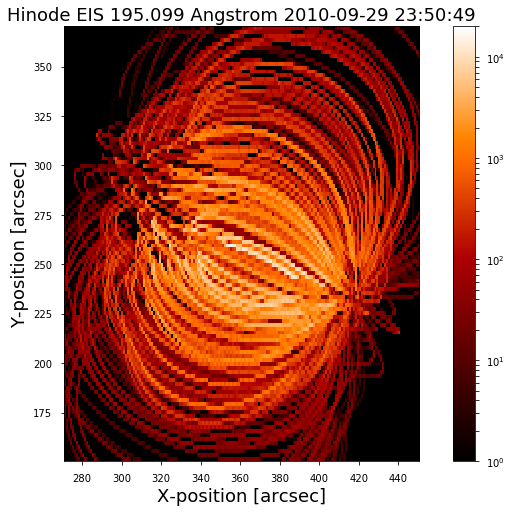

In [6]:
fig = plt.figure(figsize=(12,8))
ax = fig.gca()
im = (fe12_cut_low_cropped
 .integrated_intensity
 .plot(axes=ax,norm=matplotlib.colors.SymLogNorm(1,vmin=1,vmax=2e4))
)
fig.colorbar(im,ax=ax)

In [7]:
interpolated_wavelength = np.linspace(fe12_cut_low.wavelength[0].value,fe12_cut_low.wavelength[-1].value,200)

In [8]:
integrated_intensity = fe12_cut_low_cropped.integrated_intensity
intensities = []
doppler_shifts = []
for i in range(fe12_cut_low_cropped.data.shape[0]):
    for j in range(fe12_cut_low_cropped.data.shape[1]):
        if integrated_intensity.data[i,j] > 1.:
            tmp = fe12_cut_low_cropped.data.value[i,j,:]
            m_init = astropy.modeling.models.Gaussian1D(amplitude=tmp.max(),
                                                        mean=emiss_model.ions[230].resolved_wavelengths[1].value,
                                                        stddev=(fe12_cut_low_cropped.wavelength[-1] - fe12_cut_low_cropped.wavelength[0]).value/10.
                                                       )
            fitter = astropy.modeling.fitting.LevMarLSQFitter()
            m_fit = fitter(m_init,fe12_cut_low_cropped.wavelength.value,tmp)
            intensities.append(integrated_intensity.data[i,j])
            doppler_shifts.append(const.c.to(u.km/u.s)*(m_fit.mean.value/emiss_model.ions[230].resolved_wavelengths[1].value - 1.))

In [9]:
intensities = np.array(intensities)
doppler_shifts = u.Quantity(doppler_shifts)

In [10]:
df_low = pandas.DataFrame({'Intensity':intensities,'Doppler Shift':doppler_shifts.value})

### High-frequency Heating

In [11]:
channel1_cube_high = EISCube('/home/wtb2/Desktop/test_ar_analysis/high_frequency/170-210/map_t000750.h5')
i_wave = np.argwhere(np.isclose(channel1_cube_high.wavelength.value,
                       emiss_model.ions[230].resolved_wavelengths[1].value,atol=1e-2,rtol=0.))[0][0]
fe12_cut_high = channel1_cube_high[i_wave-10:i_wave+10]
fe12_cut_high_cropped = fe12_cut_high.submap(u.Quantity([270,450],u.arcsec),u.Quantity([150,370],u.arcsec))

/home/wtb2/anaconda3/envs/systematic-ar-study/lib/python3.5/site-packages/sunpy/map/mapbase.py:1593: Warning: WCSAxes is installed but not being used. Plots may not have the expected behaviour.
  Warning)


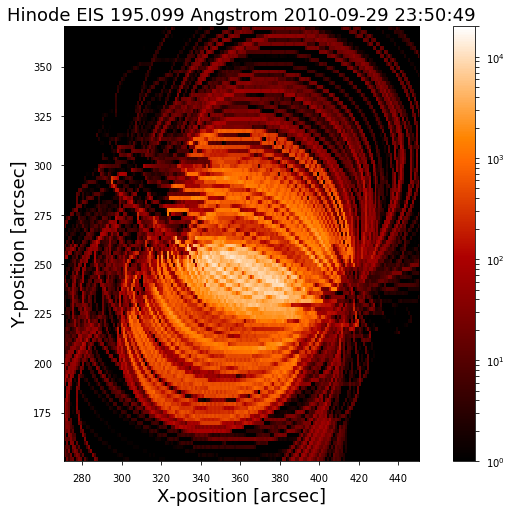

In [12]:
fig = plt.figure(figsize=(12,8))
ax = fig.gca()
im = (fe12_cut_high_cropped
 .integrated_intensity
 .plot(axes=ax,norm=matplotlib.colors.SymLogNorm(1,vmin=1,vmax=2e4))
)
fig.colorbar(im,ax=ax)

In [13]:
interpolated_wavelength = np.linspace(fe12_cut_high.wavelength[0].value,fe12_cut_high.wavelength[-1].value,200)
integrated_intensity = fe12_cut_high_cropped.integrated_intensity
intensities = []
doppler_shifts = []
for i in range(fe12_cut_high_cropped.data.shape[0]):
    for j in range(fe12_cut_high_cropped.data.shape[1]):
        if integrated_intensity.data[i,j] > 1.:
            tmp = fe12_cut_high_cropped.data.value[i,j,:]
            m_init = astropy.modeling.models.Gaussian1D(amplitude=tmp.max(),
                                                        mean=emiss_model.ions[230].resolved_wavelengths[1].value,
                                                        stddev=(fe12_cut_high_cropped.wavelength[-1] - fe12_cut_high_cropped.wavelength[0]).value/10.
                                                       )
            fitter = astropy.modeling.fitting.LevMarLSQFitter()
            m_fit = fitter(m_init,fe12_cut_high_cropped.wavelength.value,tmp)
            intensities.append(integrated_intensity.data[i,j])
            doppler_shifts.append(const.c.to(u.km/u.s)*(m_fit.mean.value/emiss_model.ions[230].resolved_wavelengths[1].value - 1.))

In [14]:
intensities = np.array(intensities)
doppler_shifts = u.Quantity(doppler_shifts)
df_high = pandas.DataFrame({'Intensity':intensities,'Doppler Shift':doppler_shifts.value})

## Plotting

In [63]:
hist_im,x_edges,y_edges = np.histogram2d(df_low['Doppler Shift'],df_low['Intensity'],
                                         bins=(
                                               #np.linspace(-100,100,50),
                                               np.sort(np.hstack([-np.logspace(-0.5,np.log10(3e2),25),
                                                                  np.logspace(-0.5,np.log10(3e2),25)])),
                                               np.logspace(0,np.log10(1.6e4),50)
                                               #np.linspace(0,16e3,50)
                                              )
                                        )

In [64]:
ymesh,xmesh = np.meshgrid((y_edges[:-1] + y_edges[1:])/2.,(x_edges[:-1] + x_edges[1:])/2)

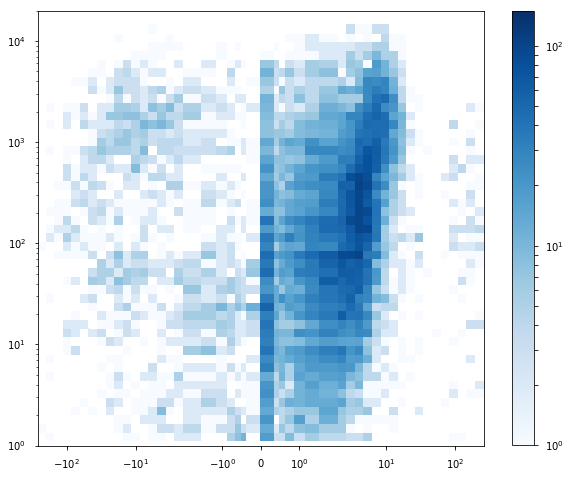

In [65]:
plt.figure(figsize=(10,8))
cmap = plt.get_cmap('Blues')
cmap.set_bad(color='w')
plt.pcolormesh(xmesh,ymesh,hist_im,cmap=cmap,norm=matplotlib.colors.LogNorm(1,1.5e2))
plt.yscale('log')
plt.xscale('symlog')
#plt.xlim([-100,100])
plt.ylim([1,2e4])
plt.colorbar()

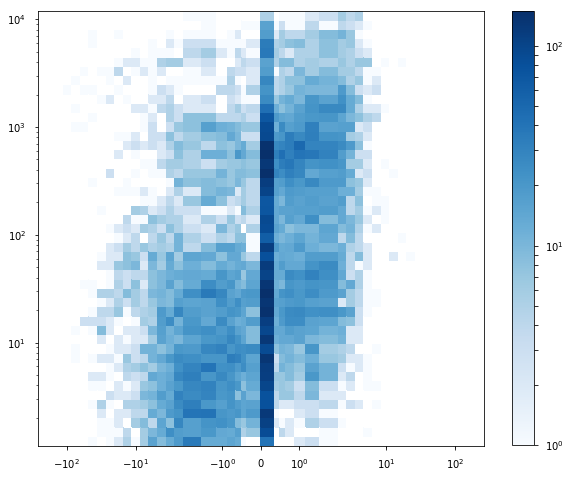

In [67]:
hist_im,x_edges,y_edges = np.histogram2d(df_high['Doppler Shift'],df_high['Intensity'],
                                         bins=(
                                               #np.linspace(-100,100,50),
                                               np.sort(np.hstack([-np.logspace(-0.5,np.log10(3e2),25),
                                                                  np.logspace(-0.5,np.log10(3e2),25)])),
                                               np.logspace(0,np.log10(1.6e4),50)
                                               #np.linspace(0,16e3,50)
                                              )
                                        )
ymesh,xmesh = np.meshgrid((y_edges[:-1] + y_edges[1:])/2.,(x_edges[:-1] + x_edges[1:])/2)
plt.figure(figsize=(10,8))
plt.pcolormesh(xmesh,ymesh,hist_im,cmap=cmap,norm=matplotlib.colors.LogNorm(1,1.5e2))
plt.yscale('log')
plt.xscale('symlog')
#plt.xlim([-100,100])
plt.ylim([0,1.2e4])
plt.colorbar()

(-300, 100)

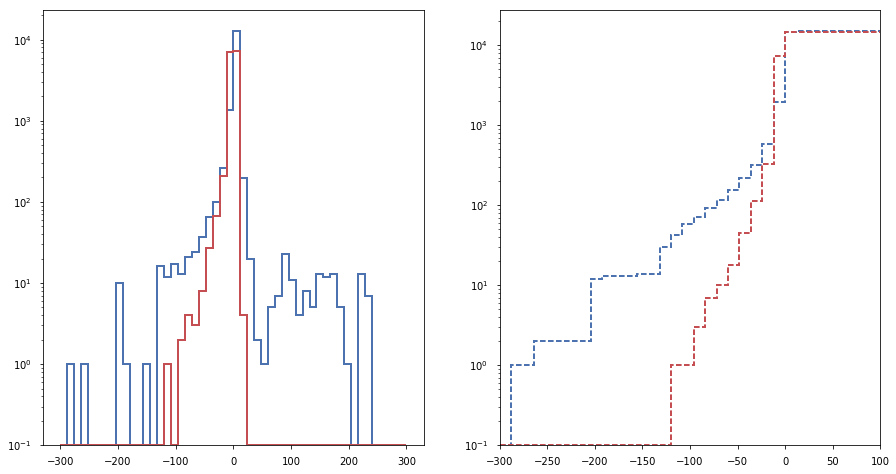

In [76]:
fig,axes = plt.subplots(1,2,figsize=(15,8))
h = axes[0].hist(df_low['Doppler Shift'],bins=50,range=(-300,300),log=True,histtype='step',lw=2,color=sns.color_palette('deep')[0])
h = axes[1].hist(df_low['Doppler Shift'],bins=50,range=(-300,300),log=True,histtype='step',lw=2,color=sns.color_palette('deep')[0],
            cumulative=True,ls='--')
h = axes[0].hist(df_high['Doppler Shift'],bins=50,range=(-300,300),log=True,histtype='step',lw=2,color=sns.color_palette('deep')[2])
h = axes[1].hist(df_high['Doppler Shift'],bins=50,range=(-300,300),log=True,histtype='step',lw=2,color=sns.color_palette('deep')[2],
            cumulative=True,ls='--')
axes[1].set_xlim([-300,100])
#axes[0].set_xlim([-100,100])